# Bag of pattern feature

Linear time method for classify time series using 1-NN approach. The method consist on generate all the sub-sequences of length $S$ from the timeseries, transforming each sub-sequence into a SAX word, generating a Bag-of-Patter representation.  

For irregular time series support the following modifications are made:

1. sub-sequence length will be defined based on time window instead of number of samples
2. sub-sequences with empty segments will be represented with special character on the SAX word.


## Step by step execution

Bag-of-Pattern features is a secuential process composed of several steps. Here we will show them based on the implemented source code using a **small dataset of regular time series**

In [1]:
import sys
import os
from collections import defaultdict
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), '..')))
import numpy as np
from src.bopf.bopf import BagOfPatternFeature
from src.bopf.bopf_finder import bopf_param_finder_mp, bopf_best_classifier
from src.utils import sort_trim_arr
from src.bopf.classifier import classify, classify2
import matplotlib.pyplot as plt
import time
import pandas as pd
from scipy.stats import f_oneway
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score, accuracy_score
import itertools
%matplotlib inline

c:\programdata\miniconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\programdata\miniconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


1. instanciate the main class

In [2]:
# special_character set to FALSE when using regular time series
bopf = BagOfPatternFeature(special_character=False)

2. load the dataset. In this case we will use Car dataset from UCR Archive which has 60 train samples and 60 test samples

In [3]:
%%time
# path windows
path = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TRAIN.tsv"
bopf.load_dataset(path, fmt="file")
print("train size:", bopf.m, "Ts len:", len(bopf.dataset[0]))

train size: 24 Ts len: 350
Wall time: 2.93 ms


3. compute the CUMSUM matrix, needed for the linear time PAA computation.

In [4]:
%%time
bopf.cumsum()

Wall time: 12.7 ms


4. get the bag-of-pattern representation for each time series. Input parameters are:

    - Word length (wd): the number of letter within each word
    - Sub-sequence width (wl): the size of each sub-sequence, input is a fraction ($[0, 1]$) of the whole time series width 

In [12]:
%%time
wd = 4
wl = 0.025
bopf.bop(wd, wl, verbose=False)

Wall time: 341 ms


D:\tesis\tesis\src\bopf\bopf.py:338: RuntimeWarning: divide by zero encountered in double_scalars
  paa = (avgsub - meanx) / sigmax


5. adjust the labels, getting the counts of time series on each class and an index array for each time series which lead to its label

In [13]:
%%time
bopf.adjust_label_set()

Wall time: 0 ns


6. Perform ANOVA F Test for discriminating the best features of the bag-of-pattern representation

In [14]:
%%time
bopf.anova()

Wall time: 18.6 ms


7. drop all features with ANOVA F value 0 and sort the rest in decreasing order

In [15]:
%%time
bopf.anova_sort()
print("bopf features will be reduced from %d to %d" % (bopf.bopsize, bopf.fea_num))

bopf features will be reduced from 256 to 146
Wall time: 0 ns


8. sort and trim the bag-of-pattern representation matrix of the whole dataset according tho the anova_sort

In [16]:
%%time
bopf.sort_trim_arr()

Wall time: 2.91 ms


9. cross validate the accuracy of classification under leave-one-out method for the reduced bag-of-pattern representation, testing different combination of the top features. The cross validation is made under two different values:
    - cross validation using class centroids for classification
    - cross validation using class TF-IDF weights for classification

In [17]:
%%time
# cross validation using centroids
bopf.crossVL(verbose=False)
print("best accuracy of CV: ", bopf.best_score, ", using the top", bopf.best_idx, "features according to ANOVA F")

best accuracy of CV:  0.6395833333333333 , using the top 21 features according to ANOVA F
Wall time: 77.1 ms


In [18]:
%%time
# cross validation using tf-idf
bopf.crossVL2()
print("best accuracy of CV2: ", bopf.best2_score, ", using the top", bopf.best2_idx, "features according to ANOVA F")

best accuracy of CV2:  0.8125 , using the top 99 features according to ANOVA F
Wall time: 123 ms


10. classify a test set using the best configuration for centroids or tf-idf

In [19]:
from src.bopf.classifier import classify, classify2
from src.utils import sort_trim_arr

In [20]:
# load the test set
bopf_t = BagOfPatternFeature(special_character=False)
path_t = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TEST.tsv"
bopf_t.load_dataset(path_t, fmt="file")

# compute CUMSUM matrix for test set
bopf_t.cumsum()

# compute bag-of-pattern representation for test set
bopf_t.bop(wd, wl)

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best_idx], 
                                  bopf_t.m, bopf.best_idx)
# classify to get predicted labels
predicted_label = classify(test_bop_sort, bopf.crossL[:bopf. c*bopf.best_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best_idx)

# get real labels of test set
real_label = np.array(bopf_t.labels)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label[i] == real_label[i]:
        count += 1

acc = count / bopf_t.m
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for centroids is:", acc)

### repeat for tf-idf

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort2 = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best2_idx], 
                                  bopf_t.m, bopf.best2_idx)
# classify to get predicted labels
predicted_label2 = classify2(test_bop_sort2, bopf.crossL2[:bopf.c*bopf.best2_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best2_idx)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label2[i] == real_label[i]:
        count += 1
        
acc2 = count / len(real_label)
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for tf-idf is:", acc2)

D:\tesis\tesis\src\bopf\bopf.py:338: RuntimeWarning: invalid value encountered in double_scalars
  paa = (avgsub - meanx) / sigmax


TOTAL DE SEGMENTOS VACIOS:  0
TOTAL DE TIMESERIES DESCARTADAS:  0
TOTAL DE ts < 6: 0
accuracy of classify using wd: 4 , wl: 0.025 , and best config for centroids is: 0.3977272727272727
accuracy of classify using wd: 4 , wl: 0.025 , and best config for tf-idf is: 0.38636363636363635


## Looking for best parameters

for best accuracy the combination parameter (wd, wl) has to be improved. In order to achive that, a number of word length ans sub-sequence width are defined and every combination is testes choosing the bests based on cross validation results.

On paper they propose:

    - wd: {3, 4, 5, 6, 7}
    - wl: {0.025, 0.05, 0.075, ..., 1}
    
and we will execute our code over UCR datasets used on the paper, looking for a resulting accuracy simmilar to the ones presented on the paper

In [3]:
wd_arr = [3, 4, 5, 6, 7]
step = 0.05
wl_arr = np.round((np.arange(int(1/step))+1)*step, 2)


def main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr):
    wd_num = len(wd_arr)
    wl_num = len(wl_arr)
    
    bopf = BagOfPatternFeature(special_character=False)
    bopf.load_dataset(train_file, fmt="file")
    bopf.cumsum()
    
    bopf_t = BagOfPatternFeature(special_character=False)
    bopf_t.load_dataset(test_file, fmt="file")
    bopf_t.cumsum()
    
    output_dict = defaultdict(list)
    
    for i in range(wd_num):
        wd = wd_arr[i]
        for j in range(wl_num):
            wl = wl_arr[j]
            print("wd: {}".format(wd) + ", wl: {}".format(wl), end="\r")
            bopf.bop(wd, wl, verbose=False)
            bopf.adjust_label_set()
            bopf.anova(verbose=False)
            bopf.anova_sort()
            bopf.sort_trim_arr(verbose=False)
            
            bopf.crossVL(verbose=False)
            output_dict["bop_features"].append(bopf.crossL[:bopf.c*bopf.best_idx])
            output_dict["bop_fea_num"].append(bopf.best_idx)
            output_dict["bop_cv_acc"].append(bopf.best_score)
            output_dict["bop_feature_index"].append(bopf.sort_index[:bopf.best_idx])
            
            bopf.crossVL2()
            output_dict["bop_features2"].append(bopf.crossL2[:bopf.c*bopf.best2_idx])
            output_dict["bop_fea_num2"].append(bopf.best2_idx)
            output_dict["bop_cv_acc2"].append(bopf.best2_score)
            output_dict["bop_feature_index2"].append(bopf.sort_index[:bopf.best2_idx])
            
            output_dict["bop_wd"].append(wd)
            output_dict["bop_wl"].append(wl)
            
    print("wd: {}".format(wd) + ", wl: {0:.2f}".format(wl))
    return bopf, bopf_t, output_dict
    
def main_test_ucr_p2(bopf, bopf_t, output_dict, top_n):
    index1 = np.argsort(output_dict["bop_cv_acc"])[::-1]
    index2 = np.argsort(output_dict["bop_cv_acc2"])[::-1]

#     avg_acc_sum = 0
#     avg_acc_sum2 = 0
#     for i in range(top_n):
#         avg_acc_sum += output_dict["bop_cv_acc"][index1[i]]
#         avg_acc_sum2 += output_dict["bop_cv_acc2"][index2[i]]

#     avg_acc = avg_acc_sum / top_n
#     avg_acc2 = avg_acc_sum2 / top_n
#     if avg_acc > avg_acc2:
        # classify using centroid
    best_centroid = -1
    best_tf_idf = -1
    rbest_centroid = -np.inf
    rbest_tf_idf = -np.inf
    for i in range(top_n):
        print(i, end="\r")
        s_index = index1[i]
        wd = output_dict["bop_wd"][s_index]
        wl = output_dict["bop_wl"][s_index]
        bopf_t.bop(wd, wl, verbose=False)
        test_bop_sort = sort_trim_arr(bopf_t.train_bop, output_dict["bop_feature_index"][s_index], 
                                  bopf_t.m, output_dict["bop_fea_num"][s_index])
        predicted_label = classify(test_bop_sort, output_dict["bop_features"][s_index], bopf.tlabel, 
                               bopf_t.m, bopf.c, output_dict["bop_fea_num"][s_index])
        real_label = np.array(bopf_t.labels)
        count = 0
        for j in range(len(real_label)):
            if predicted_label[j] == real_label[j]:
                count += 1
        acc = count / len(real_label)
        if acc > rbest_centroid:
            rbest_centroid = acc
            best_centroid = i
    s_index = index1[best_centroid]
    print("classify with best centroid and wd:", output_dict["bop_wd"][s_index], 
          ", wl:", output_dict["bop_wl"][s_index], 
          "-> cv_acc:", round(output_dict["bop_cv_acc"][s_index], 3),
          ", acc:", round(rbest_centroid, 3))
    
#     else:
    # classify using tf-idf
    # classify using centroid
    for i in range(top_n):
        print(i, end="\r")
        s_index = index2[i]
        wd = output_dict["bop_wd"][s_index]
        wl = output_dict["bop_wl"][s_index]
        bopf_t.bop(wd, wl, verbose=False)
        test_bop_sort = sort_trim_arr(bopf_t.train_bop, output_dict["bop_feature_index2"][s_index], 
                              bopf_t.m, output_dict["bop_fea_num2"][s_index])
        predicted_label = classify2(test_bop_sort, output_dict["bop_features2"][s_index], bopf.tlabel, 
                           bopf_t.m, bopf.c, output_dict["bop_fea_num2"][s_index])
        real_label = np.array(bopf_t.labels)
        count = 0
        for j in range(len(real_label)):
            if predicted_label[j] == real_label[j]:
                count += 1
        acc = count / len(real_label)
        if acc > rbest_tf_idf:
            rbest_tf_idf = acc
            best_tf_idf = i
            
    s_index = index2[best_tf_idf]
    print("classify with best tf-idf and wd:", output_dict["bop_wd"][s_index], 
          ", wl:", output_dict["bop_wl"][s_index], 
          "-> cv_acc:", round(output_dict["bop_cv_acc2"][s_index], 3),
          ", acc:", round(rbest_tf_idf, 3))
    

## Control tests on regular datasets

we will do some sanity checks by comparing accuracy of our implementation with the paper's results for the same datasets. Dataset used will be:

- FaceFour
- BeetleFly
- Car
- Haptics

all of them can be founde on [UCR Archive](https://www.cs.ucr.edu/~eamonn/time_series_data_2018/)

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

### FaceFour dataset

In [5]:
%%time
if __name__ == '__main__':
    train_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TRAIN.tsv"
    test_file = "D:/tesis/UCRArchive_2018/FaceFour/FaceFour_TEST.tsv"
    wd_arr = [3, 4, 5, 6, 7]
    step = 0.025
    wl_arr = np.round((np.arange(int(1/step))+1)*step, 3) 
    bopf3, bopf_t3, output_dict3 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

D:\tesis\tesis\src\bopf\bopf.py:319: RuntimeWarning: invalid value encountered in sqrt
  sigmax = np.sqrt(round(sumx2 / (seq_j-seq_i), 15) - round(meanx * meanx, 15))
D:\tesis\tesis\src\bopf\bopf.py:338: RuntimeWarning: divide by zero encountered in double_scalars
  paa = (avgsub - meanx) / sigmax


D:\tesis\tesis\src\bopf\bopf.py:400: RuntimeWarning: invalid value encountered in true_divide
  avgall = sumall / m
D:\tesis\tesis\src\bopf\bopf.py:404: RuntimeWarning: invalid value encountered in double_scalars
  avgc[k] = sumc[k] / self.class_count[k]
D:\tesis\tesis\src\bopf\bopf.py:540: RuntimeWarning: invalid value encountered in double_scalars
  x[i][k] = x[i][k] / self.class_count[i]
c:\programdata\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\programdata\miniconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


wd: 7, wl: 1.005
Wall time: 2min 56s


In [7]:
top_n = 50
# main_test_ucr_p2(bopf3, bopf_t3, output_dict3, top_n)
acc3, s_index3, pred_labels3, real_labels3, output_dict3, _type3, info = bopf_best_classifier(bopf3, bopf_t3,
                                                                                   output_dict3,
                                                                                   top_n)

starting classification test
wd: 5, wl: 0.5, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.966, acc balanced: 0.969
wd: 5, wl: 0.5, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.989, acc balanced: 0.99
wd: 6, wl: 0.6, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.943, acc balanced: 0.952
wd: 6, wl: 0.125, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.955, acc balanced: 0.962
wd: 5, wl: 0.425, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.977, acc balanced: 0.981
wd: 4, wl: 0.275, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.898, acc balanced: 0.905
wd: 5, wl: 0.45, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.955, acc balanced: 0.96
wd: 4, wl: 0.25, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.875, acc balanced: 0.8

wd: 4, wl: 0.4, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.977, acc balanced: 0.973
wd: 4, wl: 0.425, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.875, acc balanced: 0.877
wd: 4, wl: 0.375, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.932, acc balanced: 0.937
wd: 4, wl: 0.4, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.886, acc balanced: 0.882
wd: 4, wl: 0.35, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.966, acc balanced: 0.969
wd: 4, wl: 0.375, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.955, acc balanced: 0.952
wd: 4, wl: 0.325, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 1.0, acc balanced: 1.0
wd: 4, wl: 0.35, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.966, acc balanced: 0.959
wd: 4, wl: 0.3, method: ce

Normalized confusion matrix


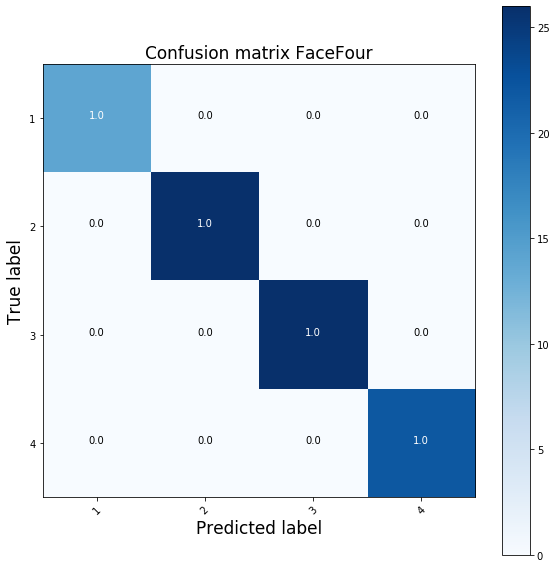

In [8]:
cnf_matrix = confusion_matrix(real_labels3, pred_labels3)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=bopf3.tlabel, normalize=True,
                      title='Confusion matrix FaceFour')

### BeetleFly dataset

In [9]:
%%time
train_file = "D:/tesis/UCRArchive_2018/BeetleFly/BeetleFly_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/BeetleFly/BeetleFly_TEST.tsv"
wd_arr = [3, 4, 5, 6, 7]
step = 0.025
wl_arr = np.round((np.arange(int(1/step))+1)*step, 3)
bopf0, bopf_t0, output_dict0 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

wd: 7, wl: 1.005
Wall time: 3min 4s


In [10]:
%%time
top_n = 30
# main_test_ucr_p2(bopf0, bopf_t0, output_dict0, top_n)
acc0, s_index0, pred_labels0, real_labels0, output_dict0, _type0, info = bopf_best_classifier(bopf0, bopf_t0,
                                                                                   output_dict0,
                                                                                   top_n)

starting classification test
wd: 5, wl: 0.525, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.55, acc balanced: 0.55
wd: 7, wl: 1.0, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.45, acc balanced: 0.45
wd: 6, wl: 0.425, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.75, acc balanced: 0.75
wd: 6, wl: 0.375, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.8, acc balanced: 0.8
wd: 5, wl: 0.075, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.65, acc balanced: 0.65
wd: 5, wl: 0.475, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.7, acc balanced: 0.7
wd: 5, wl: 0.375, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.65, acc balanced: 0.65
wd: 7, wl: 0.975, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.5, acc balanced: 0.5
wd: 6, wl: 

In [19]:
1 << (2 * 3)

64

Normalized confusion matrix


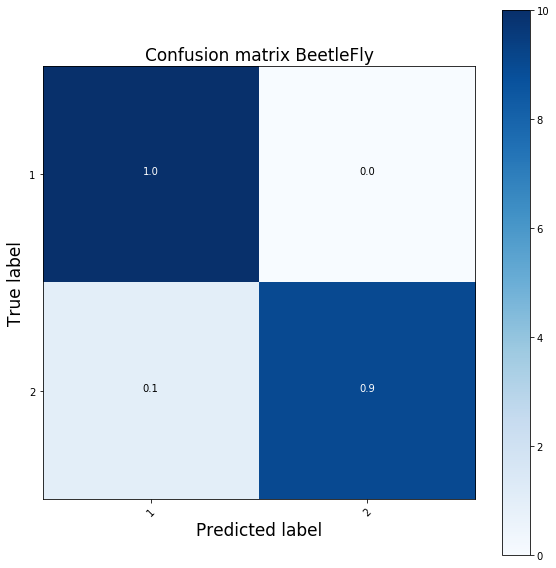

In [11]:
cnf_matrix = confusion_matrix(real_labels0, pred_labels0)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=bopf0.tlabel, normalize=True,
                      title='Confusion matrix BeetleFly')

### Car dataset

In [12]:
%%time
train_file = "D:/tesis/UCRArchive_2018/Car/Car_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/Car/Car_TEST.tsv"
wd_arr = [3, 4, 5, 6, 7]
step = 0.025
wl_arr = np.round((np.arange(int(1/step))+1)*step, 3)
bopf1, bopf_t1, output_dict1 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

wd: 7, wl: 1.005
Wall time: 7min 20s


In [14]:
%%time
top_n = 50
# main_test_ucr_p2(bopf1, bopf_t1, output_dict1, top_n)
acc1, s_index1, pred_labels1, real_labels1, output_dict1, _type1, info = bopf_best_classifier(bopf1, bopf_t1,
                                                                                   output_dict1,
                                                                                   top_n)

starting classification test
wd: 7, wl: 0.2, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.939, acc: 0.733, acc balanced: 0.733
wd: 6, wl: 0.05, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.317, acc balanced: 0.296
wd: 7, wl: 0.25, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.925, acc: 0.8, acc balanced: 0.801
wd: 7, wl: 0.025, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.233, acc balanced: 0.262
wd: 6, wl: 0.125, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.917, acc: 0.683, acc balanced: 0.687
wd: 7, wl: 0.075, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.483, acc balanced: 0.45
wd: 7, wl: 0.3, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.91, acc: 0.633, acc balanced: 0.63
wd: 6, wl: 0.025, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 1.0, acc: 0.283, acc balanc

wd: 7, wl: 0.5, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.831, acc: 0.617, acc balanced: 0.627
wd: 6, wl: 0.525, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.833, acc: 0.767, acc balanced: 0.771
wd: 5, wl: 0.4, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.83, acc: 0.667, acc balanced: 0.689
wd: 7, wl: 0.375, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.833, acc: 0.617, acc balanced: 0.607
wd: 6, wl: 0.85, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.826, acc: 0.633, acc balanced: 0.643
wd: 7, wl: 0.4, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.833, acc: 0.667, acc balanced: 0.662
wd: 7, wl: 0.825, method: tf_idf, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.825, acc: 0.65, acc balanced: 0.673
wd: 6, wl: 0.6, method: centroid, train_dropped_ts: 0.0, test_dropped_ts: 0, cv_acc: 0.833, acc: 0.633, acc balanced: 0.632
wd: 4, wl: 

Normalized confusion matrix


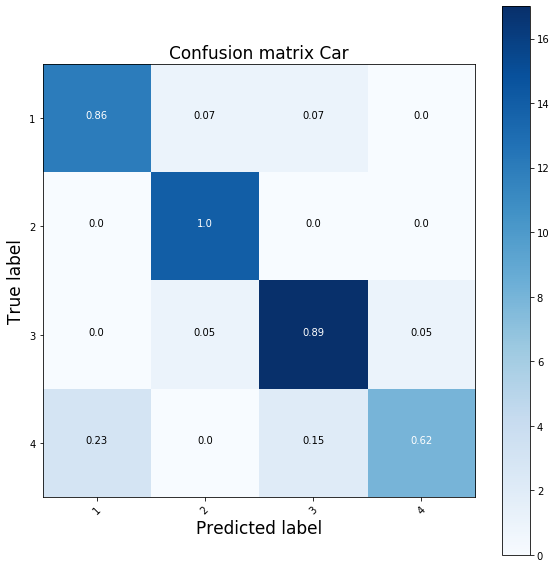

In [36]:
cnf_matrix = confusion_matrix(real_labels1, pred_labels1)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=bopf1.tlabel, normalize=True,
                      title='Confusion matrix Car')

### Haptics dataset

In [25]:
%%time
train_file = "D:/tesis/UCRArchive_2018/Haptics/Haptics_TRAIN.tsv"
test_file = "D:/tesis/UCRArchive_2018/Haptics/Haptics_TEST.tsv"
wd_arr = [3, 4, 5, 6, 7]
step = 0.025
wl_arr = np.round((np.arange(int(1/step))+1)*step, 3)
bopf4, bopf_t4, output_dict4 = main_test_ucr_p1(train_file, test_file, wd_arr, wl_arr)

wd: 7, wl: 1.005
Wall time: 35min 31s


In [27]:
%%time
top_n = 50
# main_test_ucr_p2(bopf4, bopf_t4, output_dict4, top_n)
acc, s_index, pred_labels, real_labels, output_dict, _type = bopf_best_classifier(bopf4, bopf_t4,
                                                                                   output_dict4,
                                                                                   top_n)

classify with best centroid and wd: 7 , wl: 0.275 -> cv_acc: 0.587 , acc: 0.455
classify with best tf-idf and wd: 7 , wl: 0.725 -> cv_acc: 0.69 , acc: 0.406
Wall time: 31min 42s


Normalized confusion matrix


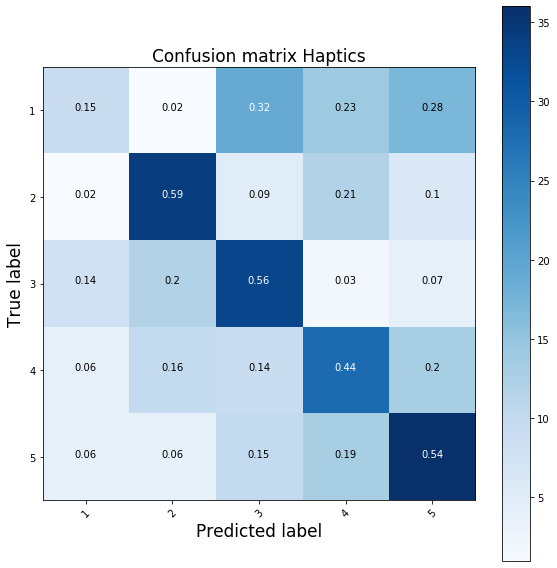

In [37]:
cnf_matrix = confusion_matrix(real_labels, pred_labels)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=bopf4.tlabel, normalize=True,
                      title='Confusion matrix Haptics')

### Comparing paper vs our results

| Dataset | Accuracy paper | Accuracy us |
| :-: | :-: | :-: |
| FaceFour | 1 | 1 |
| BeetleFly | 0.8 | 0.9|
| Car | 0.73 | 0.85 |
| Haptics | 0.42 | 0.455|

Our implementation gives in general same or better accuracy than paper's results

## Application to irregular time series

### Simple case execution

train size: 100
computing BOP...TOTAL DE SEGMENTOS VACIOS:  2842
TOTAL DE ts < 6: 0
DONE, time: 0.05858874320983887
sum of features values:  541.0
adjusting labels...DONE, time: 0.0
computing ANOVA...DONE, time: 0.002899646759033203
sorting ANOVA values...DONE, time: 0.0
sort BOP representation...DONE, time: 0.01955246925354004
count words by class...DONE, time: 0.0
first cross VL ...DONE, time: 1.1718032360076904
best accuracy of CV:  0.4910890712874297 , using the top 888 features according to ANOVA F
second cross VL ...DONE, time: 2.2194461822509766
best accuracy of CV2:  0.8960639223977118 , using the top 989 features according to ANOVA F
accuracy of classify using wd: 4 , wl: 0.2 , and best config for centroids is: 0.29
accuracy of classify using wd: 4 , wl: 0.2 , and best config for tf-idf is: 0.33
Normalized confusion matrix
[65 90 90 16 42 65 65 65 90 65 42 42 90 90 90 65 16 65 65 90 90 90 65 90
 65 90 65 90 42 90 90 42 65 90 16 16 65 90 42 65 90 65 65 90 42 90 65 65
 16 90 42 

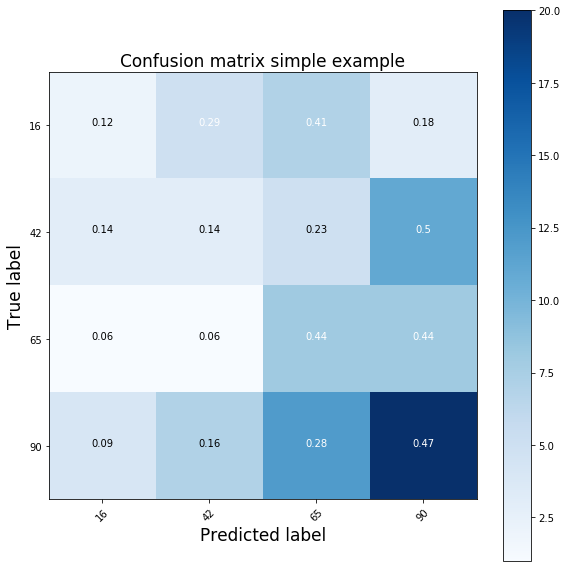

In [8]:
bopf = BagOfPatternFeature(special_character=True, strategy="special1")
path = "D:/tesis/tesis/data/plasticc_sub_dataset/"
bopf.load_dataset(path, fmt="npy", set_type="train", n1=100, n2=100, c=4)
print("train size:", bopf.m)
bopf.cumsum()
wd = 4 
wl = 0.2

print("computing BOP...", end="")
ini = time.time()
bopf.bop(wd, wl, verbose=True)
end = time.time()
print("DONE, time:", end - ini)
print("sum of features values: ", np.sum(bopf.train_bop))

print("adjusting labels...", end="")
ini = time.time()
bopf.adjust_label_set()
end = time.time()
print("DONE, time:", end - ini)

print("computing ANOVA...", end="")
ini = time.time()
bopf.anova_matrix(verbose=False)
end = time.time()
print("DONE, time:", end - ini)

print("sorting ANOVA values...", end="")
ini = time.time()
bopf.anova_sort()
end = time.time()
print("DONE, time:", end - ini)

print("sort BOP representation...", end="")
ini = time.time()
bopf.sort_trim_arr(verbose=False)
end = time.time()
print("DONE, time:", end - ini)

print("count words by class...", end="")
ini = time.time()
bopf.count_words_by_class()
end = time.time()
print("DONE, time:", end - ini)

print("first cross VL ...", end="")
ini = time.time()
bopf.crossVL(verbose=False)
# bopf.cross_VL()
end = time.time()
print("DONE, time:", end - ini)

print("best accuracy of CV: ", bopf.best_score, ", using the top", bopf.best_idx, "features according to ANOVA F")
print("second cross VL ...", end="")
ini = time.time()
bopf.crossVL2()
end = time.time()
print("DONE, time:", end - ini)
print("best accuracy of CV2: ", bopf.best2_score, ", using the top", bopf.best2_idx, "features according to ANOVA F")


# load the test set
bopf_t = BagOfPatternFeature(special_character=True, strategy="special1")
bopf_t.load_dataset(path, fmt="npy", set_type="test", n1=100, n2=100, c=4)

# compute CUMSUM matrix for test set
bopf_t.cumsum()

# compute bag-of-pattern representation for test set
bopf_t.bop(wd, wl, verbose=False)

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best_idx], 
                                  bopf_t.m, bopf.best_idx)
# classify to get predicted labels
predicted_label = classify(test_bop_sort, bopf.crossL[:bopf. c*bopf.best_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best_idx)

# get real labels of test set
real_label = np.array(bopf_t.labels)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label[i] == real_label[i]:
        count += 1

acc = count / bopf_t.m
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for centroids is:", acc)

### repeat for tf-idf

# sort and trim the bag-of-pattern representation based on the centroid best configuration
test_bop_sort2 = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best2_idx], 
                                  bopf_t.m, bopf.best2_idx)
# classify to get predicted labels
predicted_label2 = classify2(test_bop_sort2, bopf.crossL2[:bopf.c*bopf.best2_idx], bopf.tlabel, 
                               bopf_t.m, bopf.c, bopf.best2_idx)

# compute accuracy
count = 0
for i in range(len(real_label)):
    if predicted_label2[i] == real_label[i]:
        count += 1
        
acc2 = count / len(real_label)
print("accuracy of classify using wd:", wd, ", wl:", wl, ", and best config for tf-idf is:", acc2)

cnf_matrix = confusion_matrix(real_label, predicted_label2)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=bopf.tlabel, normalize=True,
                      title='Confusion matrix simple example')
print(predicted_label2, real_label)

# Experimental evaluation on sub-datasets from PLaSTiCC

6 subset were created divided in 2 groups based on the simulated metadata from PLaSTiCC dataset.

3 subset of the survey DDF (Deep Driling Fields) and 3 subset of the survey WDF (Wide-Fast-Deep), each with increasing size while keeping the train/test ratio. The sizes are 30%, 50% and 100% of the total dataset where only the 6 classes with more data where keep it.

In [92]:
def bruteforce_classifier(data_path, train_base, test_base, dmatrix):
    
    train_labels = np.load(os.path.join(data_path, train_base % "l"), allow_pickle=True)
    test_labels = np.load(os.path.join(data_path, test_base % "l"), allow_pickle=True)

    n = len(train_labels)
    m = len(test_labels)
    pred_labels = []
    for j in range(m):
        dmin = np.inf
        mink = -1
        for i in range(n):
            if dmatrix[i][j] < dmin:
                dmin = dmatrix[i][j]
                mink = i

        pred_labels.append(train_labels[mink])

    balanced_acc = balanced_accuracy_score(test_labels, pred_labels)
    acc = accuracy_score(test_labels, pred_labels)

    return test_labels, pred_labels, acc, balanced_acc

def bopf_classifier(data_path, train_base, test_base, wd, wl, method):
    bopf = BagOfPatternFeature(special_character=True, strategy="special1")
    bopf.load_dataset(data_path, fmt="npy", base=train_base)
    bopf.cumsum()
    
    bopf_t = BagOfPatternFeature(special_character=True, strategy="special1", test=True)
    bopf_t.load_dataset(data_path, fmt="npy", base=test_base)
    bopf_t.cumsum()
    
    bopf.bop(wd, wl, verbose=False, window_type="time")
    bopf.adjust_label_set()
    bopf.anova(verbose=False)
    bopf.anova_sort()
    bopf.sort_trim_arr(verbose=False)
    bopf.crossVL(verbose=False)
    bopf.crossVL2()
    
    bopf_t.bop(wd, wl, verbose=False, window_type="time")
    
    real_label = np.array(bopf_t.labels)
    
    if method == "centroid":
        bop_feature_index = bopf.sort_index[:bopf.best_idx]
        bop_fea_num = bopf.best_idx
        bop_features = bopf.crossL[:bopf.c * bopf.best_idx]
        
        test_bop_sort = sort_trim_arr(bopf_t.train_bop, bop_feature_index,
                                      bopf_t.m, bop_fea_num)
        predicted_label = classify(test_bop_sort, bop_features, bopf.tlabel,
                                   bopf_t.m, bopf.c, bop_fea_num)
    else:
        bop_feature_index = bopf.sort_index[:bopf.best2_idx]
        bop_fea_num = bopf.best2_idx
        bop_features = bopf.crossL2[:bopf.c * bopf.best2_idx]
        
        test_bop_sort = sort_trim_arr(bopf_t.train_bop, bop_feature_index,
                                      bopf_t.m, bop_fea_num)
        predicted_label = classify2(test_bop_sort, bop_features, bopf.tlabel,
                                   bopf_t.m, bopf.c, bop_fea_num)
    
    balanced_acc = balanced_accuracy_score(real_label, predicted_label)
    acc = accuracy_score(real_label, predicted_label)
    
    return real_label, predicted_label, acc, balanced_acc, bopf.tlabel

In [38]:
main_path = os.path.abspath(os.path.join(os.path.dirname("./Untitled.ipynb"), "..", "data"))
data_path = os.path.join(main_path, "plasticc_subsets", "ddf_wdf_split_simplified", "60_40_split")
bopf_results = os.path.join(data_path, "bopf_classification_reports")
brute_force_results = os.path.join(data_path, "brute_force_classification_reports")

#### Results DDF 30%

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


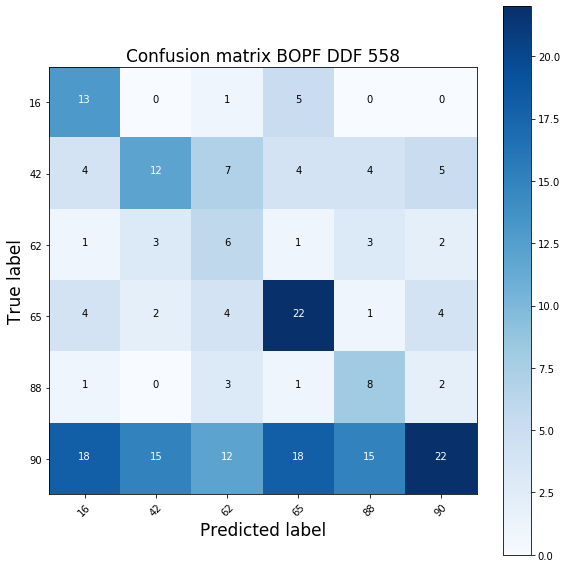

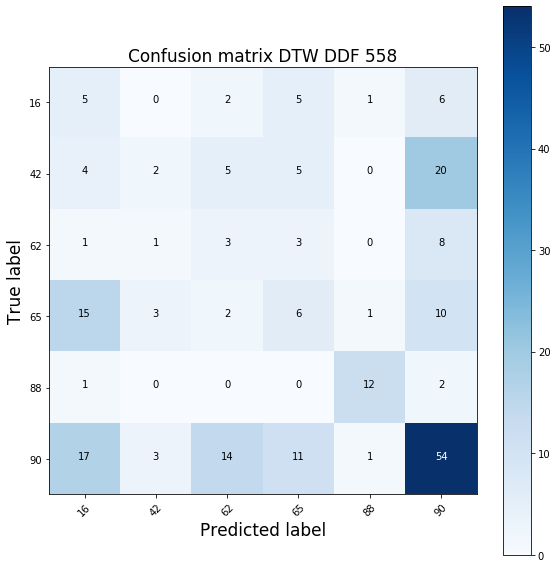

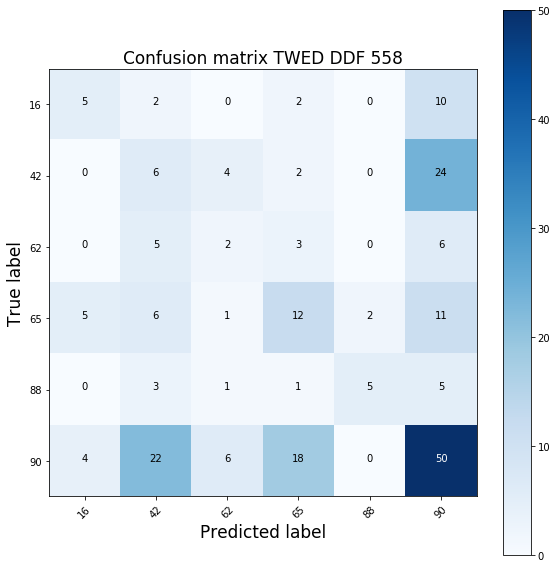

In [99]:
ddf_bopf_acc = []
ddf_dtw_acc = []
ddf_twed_acc = []
ddf_bopf_bacc = []
ddf_dtw_bacc = []
ddf_twed_bacc = []

df1 = pd.read_csv(os.path.join(brute_force_results, "report_ddf_dtw_size558.csv"))
df1["metrics"] = ["precision", "recall", "f1-score", "support"]
df1 = df1.set_index("metrics")

df2 = pd.read_csv(os.path.join(brute_force_results, "report_ddf_twed_size558.csv"))
df2["metrics"] = ["precision", "recall", "f1-score", "support"]
df2 = df2.set_index("metrics")

df3 = pd.read_csv(os.path.join(bopf_results, "report_ddf_size558.csv"))
df3["metrics"] = ["precision", "recall", "f1-score", "support"]
df3 = df3.set_index("metrics")

df3_2 = pd.read_csv(os.path.join(bopf_results, "bopf_finder_plasticc_results.csv"), header=None)
wd = df3_2.loc[0][3]
wl = df3_2.loc[0][4]
method = df3_2.loc[0][5]

train_base = "ddf_train_%s_size558.npy"
test_base = "ddf_test_%s_size558.npy"

#bopf

real_bopf, pred_bopf, acc_bopf, bacc_bopf, labels = bopf_classifier(data_path, train_base, 
                                                            test_base, wd, wl, method)
ddf_bopf_acc.append(acc_bopf)
ddf_bopf_bacc.append(bacc_bopf)

cnf_matrix = confusion_matrix(real_bopf, pred_bopf)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix BOPF DDF 558')

#dtw 

dmatrix_dtw = np.load(os.path.join(brute_force_results, "ddf_dmatrix_dtw_size558.npy"), allow_pickle=True)

real_dtw, pred_dtw, acc_dtw, bacc_dtw = bruteforce_classifier(data_path, train_base, test_base, dmatrix_dtw)

ddf_dtw_acc.append(acc_dtw)
ddf_dtw_bacc.append(bacc_dtw)

cnf_matrix = confusion_matrix(real_dtw, pred_dtw)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix DTW DDF 558')

#twed 

dmatrix_twed = np.load(os.path.join(brute_force_results, "ddf_dmatrix_twed_size558.npy"), allow_pickle=True)

real_twed, pred_twed, acc_twed, bacc_twed = bruteforce_classifier(data_path, train_base, test_base, dmatrix_twed)

ddf_twed_acc.append(acc_twed)
ddf_twed_bacc.append(bacc_twed)

cnf_matrix = confusion_matrix(real_twed, pred_twed)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix TWED DDF 558')

#### Results DDF 50%

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


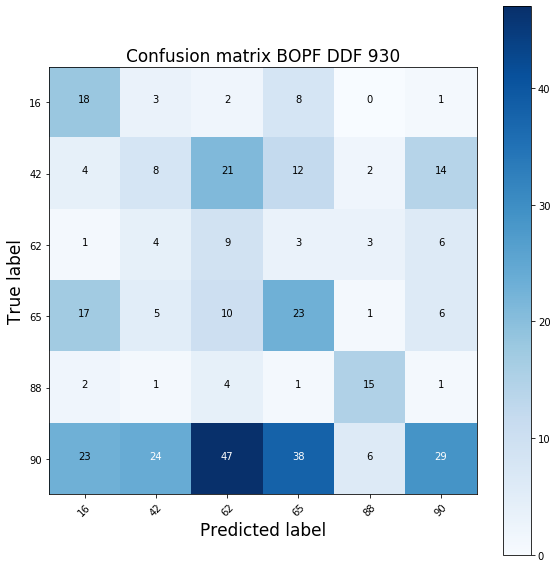

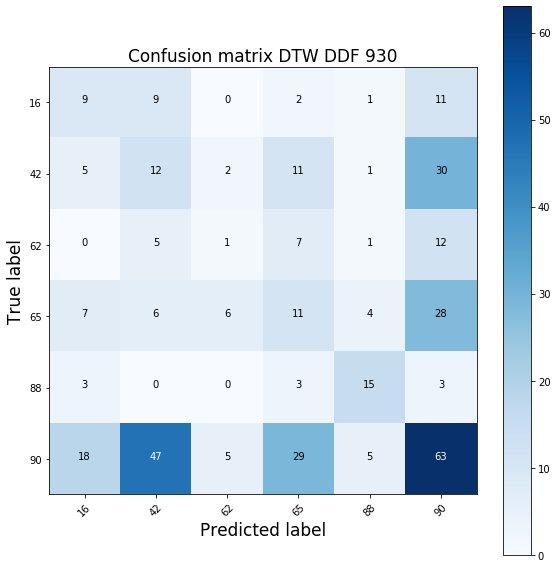

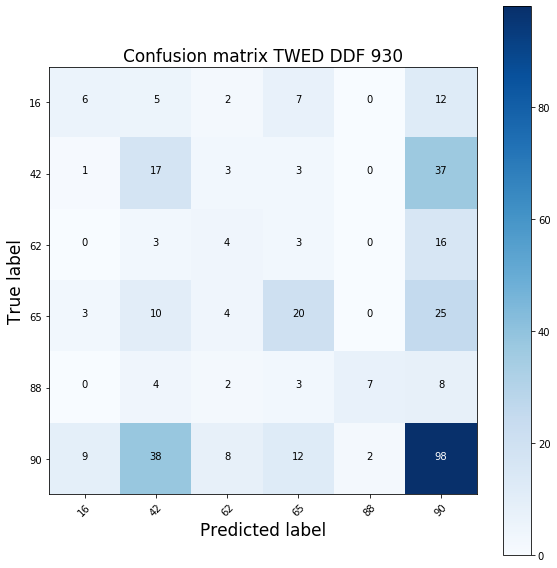

In [100]:
size = 930
df1 = pd.read_csv(os.path.join(brute_force_results, "report_ddf_dtw_size%d.csv" % size))
df1["metrics"] = ["precision", "recall", "f1-score", "support"]
df1 = df1.set_index("metrics")

df2 = pd.read_csv(os.path.join(brute_force_results, "report_ddf_twed_size%d.csv" % size))
df2["metrics"] = ["precision", "recall", "f1-score", "support"]
df2 = df2.set_index("metrics")

df3 = pd.read_csv(os.path.join(bopf_results, "report_ddf_size%d.csv" % size))
df3["metrics"] = ["precision", "recall", "f1-score", "support"]
df3 = df3.set_index("metrics")

df3_2 = pd.read_csv(os.path.join(bopf_results, "bopf_finder_plasticc_results.csv"), header=None)
wd = df3_2.loc[0][3]
wl = df3_2.loc[0][4]
method = df3_2.loc[0][5]

train_base = "ddf_train_%s_size"+str(size)+".npy"
test_base = "ddf_test_%s_size"+str(size)+".npy"

#bopf

real_bopf, pred_bopf, acc_bopf, bacc_bopf, labels = bopf_classifier(data_path, train_base, 
                                                            test_base, wd, wl, method)
ddf_bopf_acc.append(acc_bopf)
ddf_bopf_bacc.append(bacc_bopf)

cnf_matrix = confusion_matrix(real_bopf, pred_bopf)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix BOPF DDF %d' % size)

#dtw 

dmatrix_dtw = np.load(os.path.join(brute_force_results, "ddf_dmatrix_dtw_size%d.npy" % size), allow_pickle=True)

real_dtw, pred_dtw, acc_dtw, bacc_dtw = bruteforce_classifier(data_path, train_base, test_base, dmatrix_dtw)

ddf_dtw_acc.append(acc_dtw)
ddf_dtw_bacc.append(bacc_dtw)

cnf_matrix = confusion_matrix(real_dtw, pred_dtw)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix DTW DDF %d' % size)

#twed 

dmatrix_twed = np.load(os.path.join(brute_force_results, "ddf_dmatrix_twed_size%d.npy" % size), allow_pickle=True)

real_twed, pred_twed, acc_twed, bacc_twed = bruteforce_classifier(data_path, train_base, test_base, dmatrix_twed)

ddf_twed_acc.append(acc_twed)
ddf_twed_bacc.append(bacc_twed)

cnf_matrix = confusion_matrix(real_twed, pred_twed)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix TWED DDF %d' % size)

#### Results DDF 100%

In [89]:
# not executed yet

#### Results WDF 30%

Confusion matrix, without normalization
Confusion matrix, without normalization
Confusion matrix, without normalization


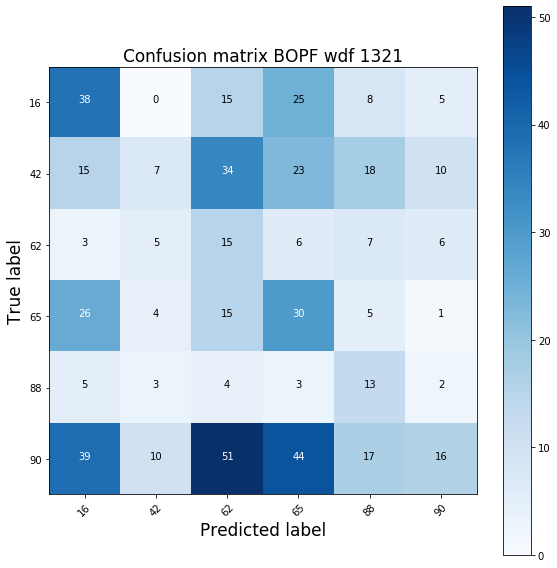

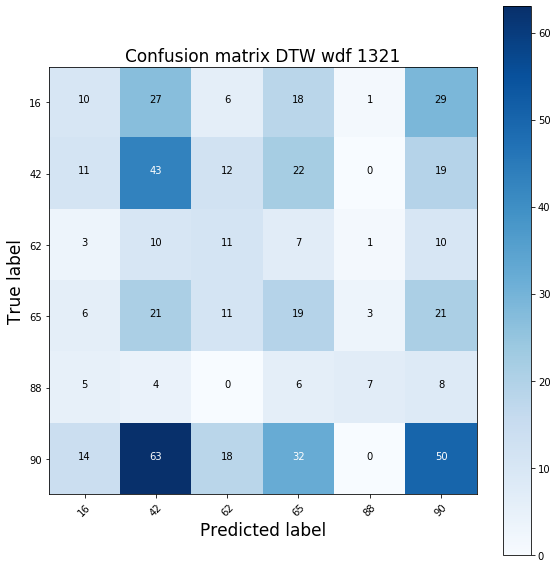

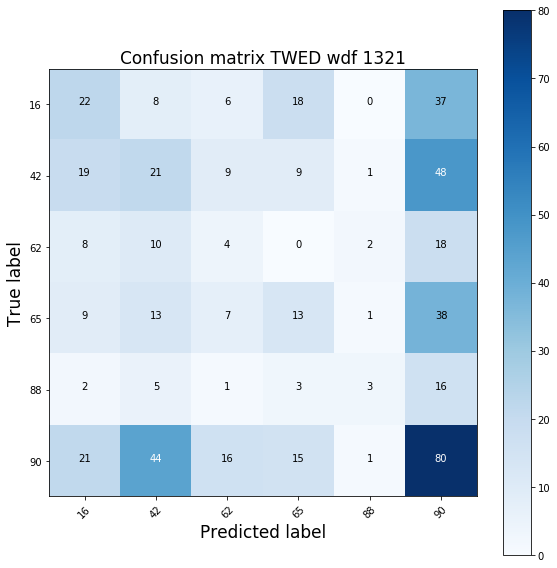

In [104]:
size = 1321
_type = "wdf"

wdf_bopf_acc = []
wdf_dtw_acc = []
wdf_twed_acc = []
wdf_bopf_bacc = []
wdf_dtw_bacc = []
wdf_twed_bacc = []


df1 = pd.read_csv(os.path.join(brute_force_results, "report_%s_dtw_size%d.csv" % (_type, size)))
df1["metrics"] = ["precision", "recall", "f1-score", "support"]
df1 = df1.set_index("metrics")

df2 = pd.read_csv(os.path.join(brute_force_results, "report_%s_twed_size%d.csv" % (_type, size)))
df2["metrics"] = ["precision", "recall", "f1-score", "support"]
df2 = df2.set_index("metrics")

df3 = pd.read_csv(os.path.join(bopf_results, "report_%s_size%d.csv" % (_type, size)))
df3["metrics"] = ["precision", "recall", "f1-score", "support"]
df3 = df3.set_index("metrics")

df3_2 = pd.read_csv(os.path.join(bopf_results, "bopf_finder_plasticc_results.csv"), header=None)
wd = df3_2.loc[4][3]
wl = df3_2.loc[4][4]
method = df3_2.loc[4][5]

train_base = _type + "_train_%s_size"+str(size)+".npy"
test_base = _type + "_test_%s_size"+str(size)+".npy"

#bopf

real_bopf, pred_bopf, acc_bopf, bacc_bopf, labels = bopf_classifier(data_path, train_base, 
                                                            test_base, wd, wl, method)
cnf_matrix = confusion_matrix(real_bopf, pred_bopf)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix BOPF %s %d' % (_type, size))

#dtw 

dmatrix_dtw = np.load(os.path.join(brute_force_results, "%s_dmatrix_dtw_size%d.npy" % (_type, size)), allow_pickle=True)

real_dtw, pred_dtw, acc_dtw, bacc_dtw = bruteforce_classifier(data_path, train_base, test_base, dmatrix_dtw)

cnf_matrix = confusion_matrix(real_dtw, pred_dtw)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix DTW %s %d' % (_type, size))

#twed 

dmatrix_twed = np.load(os.path.join(brute_force_results, "%s_dmatrix_twed_size%d.npy" % (_type, size)), allow_pickle=True)

real_twed, pred_twed, acc_twed, bacc_twed = bruteforce_classifier(data_path, train_base, test_base, dmatrix_twed)

cnf_matrix = confusion_matrix(real_twed, pred_twed)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix TWED %s %d' % (_type, size))

wdf_bopf_acc.append(acc_bopf)
wdf_dtw_acc.append(acc_dtw)
wdf_twed_acc.append(acc_twed)
wdf_bopf_bacc.append(bacc_bopf)
wdf_dtw_bacc.append(bacc_dtw)
wdf_twed_bacc.append(bacc_twed)

#### Results WDF 50%

Confusion matrix, without normalization
Confusion matrix, without normalization


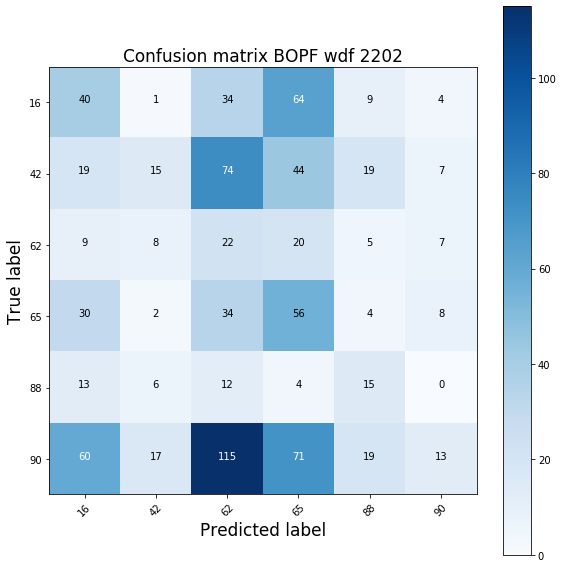

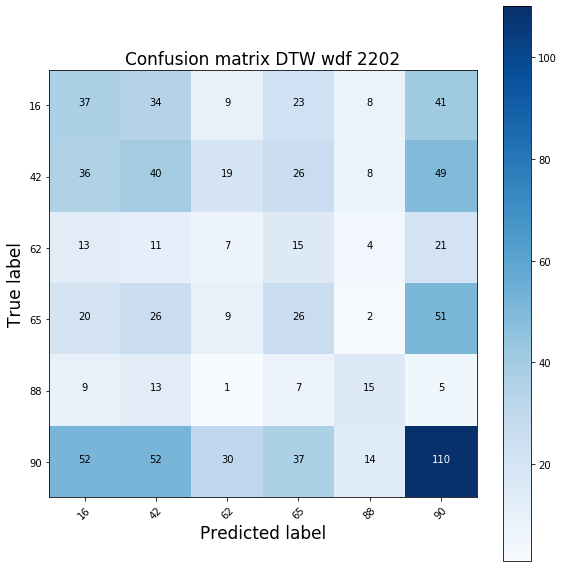

In [105]:
size = 2202
_type = "wdf"
df1 = pd.read_csv(os.path.join(brute_force_results, "report_%s_dtw_size%d.csv" % (_type, size)))
df1["metrics"] = ["precision", "recall", "f1-score", "support"]
df1 = df1.set_index("metrics")

# df2 = pd.read_csv(os.path.join(brute_force_results, "report_%s_twed_size%d.csv" % (_type, size)))
# df2["metrics"] = ["precision", "recall", "f1-score", "support"]
# df2 = df2.set_index("metrics")

df3 = pd.read_csv(os.path.join(bopf_results, "report_%s_size%d.csv" % (_type, size)))
df3["metrics"] = ["precision", "recall", "f1-score", "support"]
df3 = df3.set_index("metrics")

df3_2 = pd.read_csv(os.path.join(bopf_results, "bopf_finder_plasticc_results.csv"), header=None)
wd = df3_2.loc[4][3]
wl = df3_2.loc[4][4]
method = df3_2.loc[4][5]

train_base = _type + "_train_%s_size"+str(size)+".npy"
test_base = _type + "_test_%s_size"+str(size)+".npy"

#bopf

real_bopf, pred_bopf, acc_bopf, bacc_bopf, labels = bopf_classifier(data_path, train_base, 
                                                            test_base, wd, wl, method)
cnf_matrix = confusion_matrix(real_bopf, pred_bopf)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix BOPF %s %d' % (_type, size))

#dtw 

dmatrix_dtw = np.load(os.path.join(brute_force_results, "%s_dmatrix_dtw_size%d.npy" % (_type, size)), allow_pickle=True)

real_dtw, pred_dtw, acc_dtw, bacc_dtw = bruteforce_classifier(data_path, train_base, test_base, dmatrix_dtw)

cnf_matrix = confusion_matrix(real_dtw, pred_dtw)
fig = plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
                      title='Confusion matrix DTW %s %d' % (_type, size))

#twed 
## TWED STILL NOT EXECUTED

# dmatrix_twed = np.load(os.path.join(brute_force_results, "%s_dmatrix_twed_size%d.npy" % (_type, size)), allow_pickle=True)

# real_twed, pred_twed, acc_twed, bacc_twed = bruteforce_classifier(data_path, train_base, test_base, dmatrix_twed)

# cnf_matrix = confusion_matrix(real_twed, pred_twed)
# fig = plt.figure(figsize=(8, 8))
# plot_confusion_matrix(cnf_matrix, classes=labels, normalize=False,
#                       title='Confusion matrix TWED %s %d' % (_type, size))

wdf_bopf_acc.append(acc_bopf)
wdf_dtw_acc.append(acc_dtw)
# wdf_twed_acc.append(acc_twed)
wdf_bopf_bacc.append(bacc_bopf)
wdf_dtw_bacc.append(bacc_dtw)
# wdf_twed_bacc.append(bacc_twed)

#### Results WDF 100%

In [ ]:
# not executed yet

### Extra plots

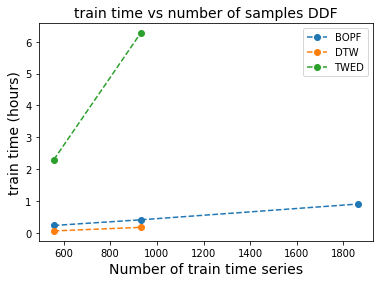

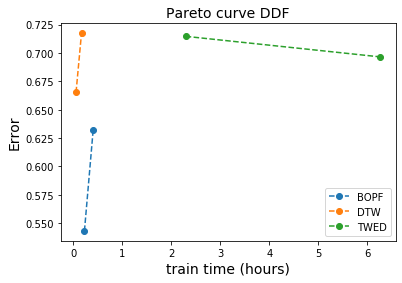

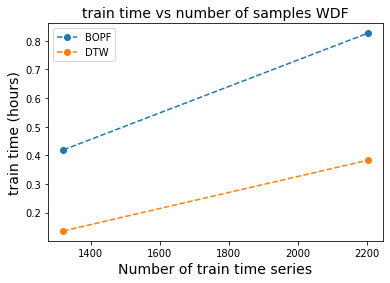

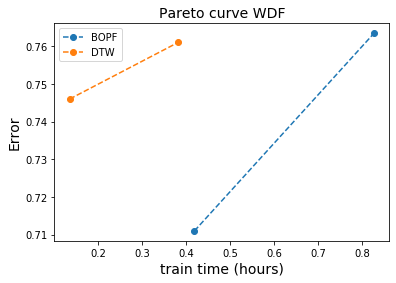

In [108]:
# excecution time
# to few points to observe any tendency
ddf_dtw = np.array([220.627, 621.332])
ddf_twed = np.array([8266.87, 22555.54])
ddf_bopf = np.array([836.94, 1474.65, 3257.65])
train_size = [558, 930, 1863]

fig = plt.figure()
plt.plot(train_size[:], ddf_bopf / 60 / 60, 'o--', label="BOPF")
plt.plot(train_size[:2], ddf_dtw / 60 / 60, 'o--', label="DTW")
plt.plot(train_size[:2], ddf_twed / 60 / 60, 'o--', label="TWED")
plt.xlabel("Number of train time series", fontsize=14)
plt.ylabel("train time (hours)", fontsize=14)
plt.title("train time vs number of samples DDF", fontsize=14)
plt.legend()

# pareto curve

ddf_bopf_err = 1 - np.array(ddf_bopf_bacc)
ddf_dtw_err = 1 - np.array(ddf_dtw_bacc)
ddf_twed_err = 1 - np.array(ddf_twed_bacc)

fig = plt.figure()
plt.plot(ddf_bopf[:2] / 60 / 60, ddf_bopf_err, 'o--', label="BOPF")
plt.plot(ddf_dtw / 60 / 60, ddf_dtw_err, 'o--', label="DTW")
plt.plot(ddf_twed / 60 / 60, ddf_twed_err, 'o--', label="TWED")
plt.xlabel("train time (hours)", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.title("Pareto curve DDF", fontsize=14)
plt.legend()

## WDF

wdf_dtw = np.array([489.173, 1377.695])
wdf_bopf = np.array([1508.01, 2974.89])
train_wdf_size = [1321, 2202]

fig = plt.figure()
plt.plot(train_wdf_size[:], wdf_bopf / 60 / 60, 'o--', label="BOPF")
plt.plot(train_wdf_size[:], wdf_dtw / 60 / 60, 'o--', label="DTW")
# plt.plot(train_size[:], ddf_twed / 60 / 60, 'o--', label="TWED")
plt.xlabel("Number of train time series", fontsize=14)
plt.ylabel("train time (hours)", fontsize=14)
plt.title("train time vs number of samples WDF", fontsize=14)
plt.legend()


wdf_bopf_err = 1 - np.array(wdf_bopf_bacc)
wdf_dtw_err = 1 - np.array(wdf_dtw_bacc)
# ddf_twed_err = 1 - np.array(ddf_twed_bacc)

fig = plt.figure()
plt.plot(wdf_bopf / 60 / 60, wdf_bopf_err, 'o--', label="BOPF")
plt.plot(wdf_dtw / 60 / 60, wdf_dtw_err, 'o--', label="DTW")
# plt.plot(wdf_twed / 60 / 60, wdf_twed_err, 'o--', label="TWED")
plt.xlabel("train time (hours)", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.title("Pareto curve WDF", fontsize=14)
plt.legend()


In [23]:
df = pd.read_csv("D:/tesis/tesis/data/bop_plasticc_results.csv")
df

,#n1,n2,c,acc,wd,wl,train_time,test_time
0,100,25,6,0.360,7,0.150,518.851137,13.849060
1,500,125,6,0.376,5,0.700,3500.945935,142.166485
2,1000,250,6,0.404,3,0.850,7773.627838,380.598793
3,2000,500,6,0.390,3,0.875,19276.173855,898.231979
4,4000,1000,6,0.392,3,0.850,43500.916891,2045.043403


Observation: the test part was executed without multiprocessig

### Getting confusion matrix for dataset 4000/1000

In [32]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=17)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=17)
    plt.xlabel('Predicted label', fontsize=17)

0.3875
accuracy [4000/1000]:  0.392
Normalized confusion matrix
              precision    recall  f1-score   support

        15.0       0.00      0.00      0.00        77
        16.0       0.33      0.50      0.40       145
        42.0       0.00      0.00      0.00       187
        62.0       0.00      0.00      0.00        76
        65.0       0.00      0.00      0.00       153
        90.0       0.41      0.88      0.56       362

    accuracy                           0.39      1000
   macro avg       0.12      0.23      0.16      1000
weighted avg       0.20      0.39      0.26      1000



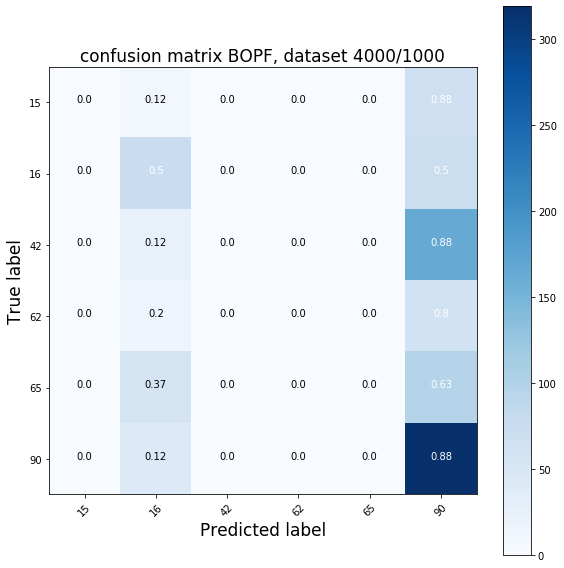

In [41]:

path = "D:/tesis/tesis/data/plasticc_subsets/scenario1_ratio_2-8/"
n1 = 4000
n2 = 1000
c = 6
wd = 3
wl = 0.85

bopf = BagOfPatternFeature(special_character=True)
bopf.load_dataset(path, fmt="npy", set_type="train", n1=n1, c=c)
bopf.cumsum()
    
bopf_t = BagOfPatternFeature(special_character=True)
bopf_t.load_dataset(path, fmt="npy", set_type="test", n1=n2, c=c)
bopf_t.cumsum()

bopf.bop(wd, wl, verbose=False)
bopf.adjust_label_set()
bopf.anova(verbose=False)
bopf.anova_sort()
bopf.sort_trim_arr(verbose=False)
bopf.crossVL(verbose=False)

bopf_t.bop(wd, wl, verbose=False)
print(bopf.best_score)
test_bop_sort = sort_trim_arr(bopf_t.train_bop, bopf.sort_index[:bopf.best_idx],
                                      bopf_t.m, bopf.best_idx)
predicted_label = classify(test_bop_sort, bopf.crossL[:bopf.c * bopf.best_idx], bopf.tlabel,
                                   bopf_t.m, bopf.c, bopf.best_idx)
real_label = np.array(bopf_t.labels)
count = 0 
for j in range(len(real_label)):
    if predicted_label[j] == real_label[j]:
        count += 1
acc = count / len(real_label)
print("accuracy [4000/1000]: ", acc)
cnf_matrix = confusion_matrix(real_label, predicted_label)
np.set_printoptions(precision=2)


class_names = [15, 16, 42, 62, 65, 90]

plt.figure(figsize=(8, 8))
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='confusion matrix BOPF, dataset %d/%d' % (n1, n2))

print(classification_report(real_label, predicted_label))


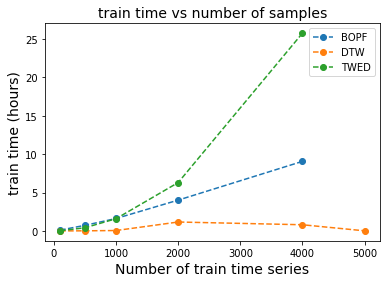

In [53]:
dtw_dist_time = np.array([1.75, 63.82, 250.05, 5574.6, 3857.38, 60.73])
dtw_train_len = [100, 500, 1000, 2000, 4000, 5000]
twed_dist_time = np.array([79.43, 1994.7, 7645.19, 30256.8, 123674.35])
twed_train_len = [100, 500, 1000, 2000, 4000]
bopf_time = np.array(df["train_time"])
bopf_train_len = twed_train_len

acc_dtw = 1 - np.array([0.2, 0.248, 0.28, 0.27, 0.258, 0.2464])
acc_twed = 1 - np.array([0.12, 0.192, 0.28, 0.366, 0.382])
acc_bopf = 1 - np.array(df["acc"])

fig = plt.figure()
plt.plot(bopf_train_len, bopf_time * (6/8) / 60 / 60, 'o--', label="BOPF")
plt.plot(dtw_train_len, dtw_dist_time * (6/8) / 60 / 60, 'o--', label="DTW")
plt.plot(twed_train_len, twed_dist_time * (6/8) / 60 / 60, 'o--', label="TWED")
plt.xlabel("Number of train time series", fontsize=14)
plt.ylabel("train time (hours)", fontsize=14)
plt.title("train time vs number of samples", fontsize=14)
plt.legend()

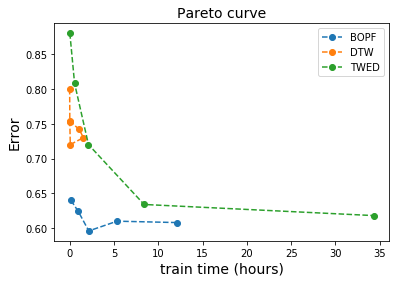

In [56]:
fig = plt.figure()
plt.plot(bopf_time / 60 / 60, acc_bopf, 'o--', label="BOPF")
plt.plot(dtw_dist_time / 60 / 60, acc_dtw, 'o--', label="DTW")
plt.plot(twed_dist_time / 60 / 60, acc_twed, 'o--', label="TWED")
plt.xlabel("train time (hours)", fontsize=14)
plt.ylabel("Error", fontsize=14)
plt.title("Pareto curve", fontsize=14)
plt.legend()

### TO-DO on datasets

1. create sub-datasets of same train/test ratio and same number of classes but changing the number of samples
2. create sub-datasets of same number of samples and classes but different train/test ratio
3. execute brute force DTW, brute force TWED and BOPF on same machine for time test